# Importing Libraries & Dataset

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wordcloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

from bs4 import BeautifulSoup

In [5]:
dataset = pd.read_csv('IMDB Dataset.csv')

# Data Preperation & Vizulization

In [6]:
dataset.head(), dataset.tail()

(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
                                                   review sentiment
 49995  I thought this movie did a down right good job...  positive
 49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
 49997  I am a Catholic taught in parochial elementary...  negative
 49998  I'm going to have to disagree with the previou...  negative
 49999  No one expects the Star Trek movies to be high...  negative)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
dataset.shape

(50000, 2)

In [9]:
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [10]:
dataset.empty

False

In [11]:
dataset.groupby("sentiment").describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  You do realize that you've been watching the E...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

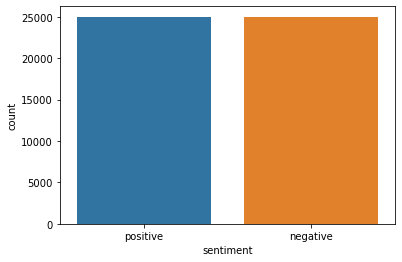

In [12]:
ax = sns.countplot(x="sentiment", data=dataset)

In [13]:
dataset['sentence_length'] = dataset['review'].apply(len)

In [14]:
dataset.head()

,review,sentiment,sentence_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


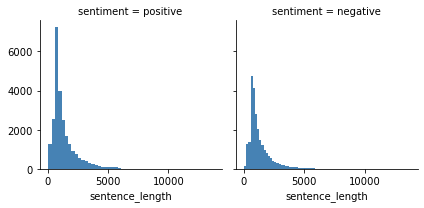

In [15]:
ax = sns.FacetGrid(dataset, col="sentiment")
ax.map(plt.hist, "sentence_length", color="steelblue", bins=50)

In [16]:
dataset.sort_values('sentence_length', ascending=False)

,review,sentiment,sentence_length
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,13704
40521,There's a sign on The Lost Highway that says:<...,positive,12988
31240,"(Some spoilers included:)<br /><br />Although,...",positive,12930
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,12129
5708,**Attention Spoilers**<br /><br />First of all...,positive,10363
...,...,...,...
19874,This movie is terrible but it has some good ef...,negative,52
28920,Primary plot!Primary direction!Poor interpreta...,negative,51
40817,I hope this group of film-makers never re-unites.,negative,49
31072,"What a script, what a story, what a mess!",negative,41


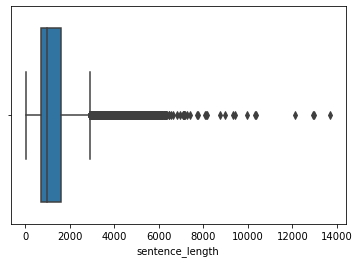

In [17]:
ax = sns.boxplot(x=dataset["sentence_length"])

In [18]:
dataset['sentence_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: sentence_length, dtype: float64

In [19]:
dataset.quantile(0.9)

sentence_length    2581.0
Name: 0.9, dtype: float64

# Cleaning Text and Tag words

In [20]:
#nltk.download('stopwords')
#nltk.download('wordnet')
wlm = WordNetLemmatizer()
all_stopwords = stopwords.words('english')

def review_to_words(text):
    review = BeautifulSoup(text).get_text()
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [wlm.lemmatize(word) for word in review if not word in set(all_stopwords)]
    return review

dataset['words'] = dataset['review'].apply(review_to_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\psidd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\psidd\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [21]:
dataset.head()

,review,sentiment,sentence_length,words
0,One of the other reviewers has mentioned that ...,positive,1761,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,positive,998,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,748,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,"[petter, mattei, love, time, money, visually, ..."


In [22]:
dataset['review'] = dataset['words'].apply(lambda x: ' '.join(map(str, x)))
dataset.head()

,review,sentiment,sentence_length,words
0,one reviewer mentioned watching oz episode hoo...,positive,1761,"[one, reviewer, mentioned, watching, oz, episo..."
1,wonderful little production filming technique ...,positive,998,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,positive,926,"[thought, wonderful, way, spend, time, hot, su..."
3,basically family little boy jake think zombie ...,negative,748,"[basically, family, little, boy, jake, think, ..."
4,petter mattei love time money visually stunnin...,positive,1317,"[petter, mattei, love, time, money, visually, ..."


In [23]:
pos_review = dataset[dataset['sentiment'] == 'positive']
neg_review = dataset[dataset['sentiment'] == 'negative']

In [24]:
text = ' '.join(pos_review['review'].astype(str).tolist())

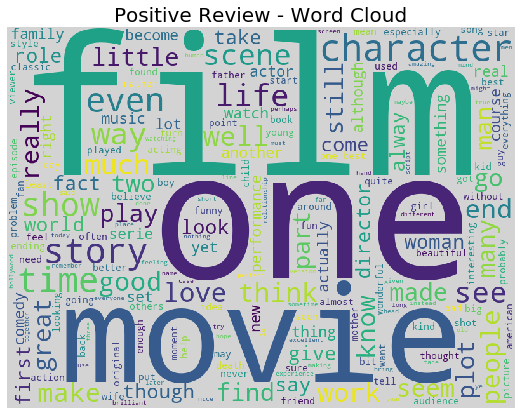

In [25]:
fig_wordcloud = wordcloud.WordCloud(background_color='lightgrey',
                                    colormap='viridis', width=800, height=600).generate(text)
plt.figure(figsize=(10,7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title('Positive Review - Word Cloud', fontsize=20 )
plt.show()

In [26]:
text = ' '.join(neg_review['review'].astype(str).tolist())

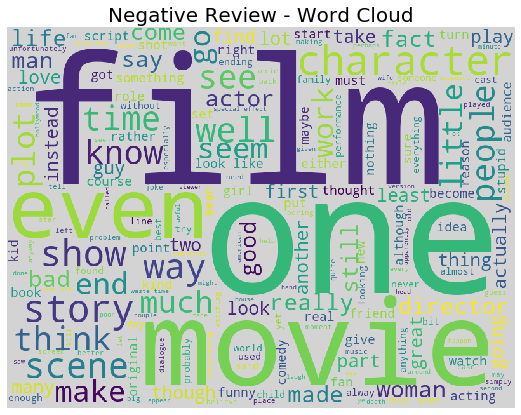

In [27]:
fig_wordcloud = wordcloud.WordCloud(background_color='lightgrey',
                                    colormap='viridis', width=800, height=600).generate(text)
plt.figure(figsize=(10,7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title('Negative Review - Word Cloud', fontsize=20 )
plt.show()

# Bag of word model

In [47]:
cv = CountVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
cv_matrix = cv.fit_transform(dataset.review)

## Train Test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(cv_matrix, dataset.sentiment, test_size=0.3, random_state=0)

## Linear SVC

In [49]:
svc_m = LinearSVC()

In [50]:
svc_m.fit(X_train, y_train)

C:\Users\psidd\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [51]:
y_pred = svc_m.predict(X_test)

In [52]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [53]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6694  846]
 [ 770 6690]]


0.8922666666666667

## Naive Bayes model 

In [54]:
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [55]:
y_pred = NB.predict(X_test)

In [56]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,negative


In [57]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6666  874]
 [ 855 6605]]


0.8847333333333334

## SGDC Classifier

In [58]:
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
y_pred = SGDC.predict(X_test)

In [60]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [61]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6713  827]
 [ 825 6635]]


0.8898666666666667

# Term Frequency-Inverse Document Frequency model

In [28]:
tfid = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
tfid_matrix = tfid.fit_transform(dataset.review)

## Train Test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(tfid_matrix, dataset.sentiment, test_size=0.3, random_state=0)

## Linear SVC

In [31]:
svc_m = LinearSVC()

In [32]:
svc_m.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [33]:
y_pred = svc_m.predict(X_test)

In [34]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [35]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6772  768]
 [ 642 6818]]


0.906

## Naive Bayes model 

In [36]:
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
y_pred = NB.predict(X_test)

In [39]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [40]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6644  896]
 [ 783 6677]]


0.8880666666666667

## SGDC Classifier

In [43]:
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
y_pred = SGDC.predict(X_test)

In [45]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_output

,Actual,Predicted
11841,positive,positive
19602,negative,negative
45519,negative,positive
25747,positive,positive
42642,positive,positive
...,...,...
38344,positive,positive
49984,negative,negative
32624,positive,positive
46437,positive,positive


In [46]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6620  920]
 [ 637 6823]]


0.8962

# Conclusion

Out of all model above, it looks like TF-IDF method with linear SVC model is giving us more accuracy than other model

In [66]:
tfid = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
tfid_matrix = tfid.fit_transform(dataset.review)

X_train, X_test, y_train, y_test = train_test_split(tfid_matrix, dataset.sentiment, test_size=0.3, random_state=0)

svc_m = LinearSVC()
svc_m.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [69]:
X_test

<15000x664619 sparse matrix of type '<class 'numpy.float64'>'
	with 2431854 stored elements in Compressed Sparse Row format>